# Text Classification Features and NLTK Classification Code #
This example is based on the NLTK book and uses the Names collection to guess gender of names.

In [1]:
# show plots inline
%matplotlib inline 
import nltk
from nltk.corpus import names
import random

First, recall from Chapter 4 that the Names corpus contains 8,000 first names categorized by gender. The male and female names are stored in separate files. Which names occur in both fiels, and so are ambiguous for gender?

In [2]:
names = nltk.corpus.names
names.fileids()
['female.txt', 'male.txt']
male_names = names.words('male.txt')
female_names = names.words('female.txt')
both_genders = [w for w in male_names if w in female_names]
print("Num ambiguous names: " + str(len(both_genders)))
both_genders[:10]

Num ambiguous names: 365


[u'Abbey',
 u'Abbie',
 u'Abby',
 u'Addie',
 u'Adrian',
 u'Adrien',
 u'Ajay',
 u'Alex',
 u'Alexis',
 u'Alfie']


Recall also from Chapter 4 the observation that names tend to have certain patterns or features (perhaps for cultural reasons).  For example, it is well known in English that names ending in the letter a are almost always female. 

This can be seen from a simple frequency computation.  Remember that name[-1] is the last letter of name.

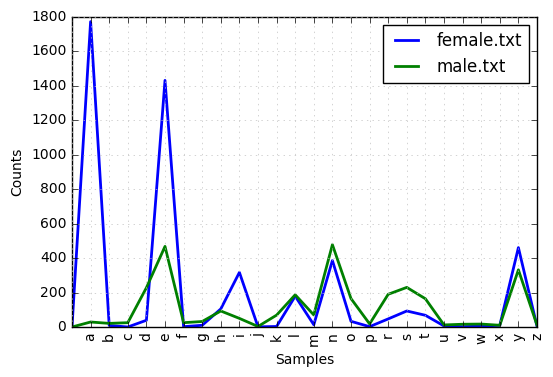

In [3]:
cfd = nltk.ConditionalFreqDist(
           (fileid, name[-1])
           for fileid in names.fileids()
           for name in names.words(fileid))
cfd.plot()

Now we'll try to find other kinds of featues in order to make a name gender classifier.

** A feature recognition function **

In [4]:
def gender_features(word):
    return {'last_letter': word[-1]}

gender_features('Samantha')

{'last_letter': 'a'}

** Create name datasets ** 

In [5]:
def create_name_data():
    male_names = [(name, 'male') for name in names.words('male.txt')]
    female_names = [(name, 'female') for name in names.words('female.txt')]
    allnames = male_names + female_names
    
    # Randomize the order of male and female names, and de-alphabatize
    random.shuffle(allnames)
    return allnames

names_data = create_name_data()

** Make Training, Development, and Test Data Sets **

We  need a development set to test our features on before testing on the real test set. So let's redo our division of the data. In this case we do the dividing up before applying the feature selection so we can keep track of the names.

In [7]:
# This function allows experimentation with different feature definitions
# items is a list of (key, value) pairs from which features are extracted and training sets are made
# Feature sets returned are dictionaries of features

# This function also optionally returns the names of the training, development, 
# and test data for the purposes of error checking

def create_training_sets (feature_function, items, return_items=False):
    # Create the features sets.  Call the function that was passed in.
    # For names data, key is the name, and value is the gender
    featuresets = [(feature_function(key), value) for (key, value) in items]
    
    # Divided training and testing in thirds.  Could divide in other proportions instead.
    third = int(float(len(featuresets)) / 3.0)
    
    train_set, dev_set, test_set = featuresets[0:third], featuresets[third:third*2], featuresets[third*2:]
    train_items, dev_items, test_items = items[0:third], items[third:third*2], items[third*2:]
    if return_items == True:
        return train_set, dev_set, test_set, train_items, dev_items, test_items
    else:
        return train_set, dev_set, test_set

** Train the nltk classifier on the training data, with the first definition of features  **

We are using the Naive Bayes Classifier here.  This is one of several other possible options, but it's a simple and effective one, so let's stick with it for now.

In [8]:
# note that this passes in a function name as an argument (gender_features)

train_set, dev_set, test_set = create_training_sets(gender_features, names_data)
cl = nltk.NaiveBayesClassifier.train(train_set)

** Test the classifier on some examples **

In [9]:
print ("Carl: " + cl.classify(gender_features('Carl')))
print ("Carla: " + cl.classify(gender_features('Carla')))
print ("Carly: " + cl.classify(gender_features('Carly')))
print ("Carlo: " + cl.classify(gender_features('Carlo')))
print ("Carlos: " + cl.classify(gender_features('Carlos')))


Carl: male
Carla: female
Carly: female
Carlo: male
Carlos: male


In [10]:
print ("Carli: " + cl.classify(gender_features('Carli')))
print ("Carle: " + cl.classify(gender_features('Carle')))
print ("Charles: " + cl.classify(gender_features('Charles')))
print ("Carlie: " + cl.classify(gender_features('Carlie')))
print ("Charlie: " + cl.classify(gender_features('Charlie')))

Carli: female
Carle: female
Charles: male
Carlie: female
Charlie: female


** Run the NLTK evaluation function on the development set **


In [11]:
print ("%.3f" % nltk.classify.accuracy(cl, dev_set))

0.748


** Run the NLTK feature inspection function on the classifier **


In [12]:
cl.show_most_informative_features(15)

Most Informative Features
             last_letter = u'a'           female : male   =     58.0 : 1.0
             last_letter = u'k'             male : female =     30.4 : 1.0
             last_letter = u'm'             male : female =     12.1 : 1.0
             last_letter = u'r'             male : female =     11.6 : 1.0
             last_letter = u'f'             male : female =     10.5 : 1.0
             last_letter = u'd'             male : female =     10.5 : 1.0
             last_letter = u'o'             male : female =      5.3 : 1.0
             last_letter = u'z'             male : female =      5.0 : 1.0
             last_letter = u't'             male : female =      4.5 : 1.0
             last_letter = u'i'           female : male   =      4.4 : 1.0
             last_letter = u'u'             male : female =      4.3 : 1.0
             last_letter = u's'             male : female =      3.8 : 1.0
             last_letter = u'b'             male : female =      3.5 : 1.0

** Let's add some more features to improve results **

*Notice that we are not looking at our test set!  The development set is for improving the features and parameters of the machine learning algorithm.*

In [71]:

#Modified code in gender_features3
from collections import Counter
def gender_features2(word):
    features = {}
    word = word.lower()
    features['last'] = word[-1]
    features['first'] = word[:1]
    features['second'] = word[1:2] # get the 'h' in Charlie?
    return features
gender_features2('Samantha')

def gender_features3(word):
    features = {}
    word = word.lower()
    features['last'] = word[-1]
    features['first'] = word[:1]
    features["length"]=len(word)
    pairs=dict(Counter(x+y for x, y in zip(*[word[i:] for i in range(2)])).most_common()) # Identifiying 
    #the most common pairs of letters in a given word
    features = dict(features.items() + pairs.items())
    features["last_2"]=word[-2:] # Extracting the last 2 letters in a word or name
    features["first_2"]=word[:2]
    
#   features['second'] = word[1:2] # get the 'h' in Charlie?
    return features
gender_features2('Samantha')  
print gender_features3("Samantha")

{'ma': 1, 'first_2': 'sa', 'last_2': 'ha', 'am': 1, 'an': 1, 'length': 8, 'th': 1, 'last': 'a', 'sa': 1, 'ha': 1, 'nt': 1, 'first': 's'}


** We wrote the code so that we can easily pass in the new feature function. Lets see if this improves the results on the development set.**

Note again that we are not testing on the test set ... only the development set.

In [72]:
train_set2, dev_set2, test_set2 = create_training_sets(gender_features2, names_data)
cl2 = nltk.NaiveBayesClassifier.train(train_set2)
print ("%.3f" % nltk.classify.accuracy(cl2, dev_set2))

0.762


**Compare results on gender_features2 to gender_features3, both on the dev set.**

In [73]:
train_set3, dev_set3, test_set3 = create_training_sets(gender_features3, names_data)
cl3 = nltk.NaiveBayesClassifier.train(train_set3)
print ("%.3f" % nltk.classify.accuracy(cl3, dev_set3))

0.804


** Let's hand check some of the harder cases ... oops some are right but some are now wrong. **

In [74]:
print ("Carli: " + cl2.classify(gender_features2('Carli')))
print ("Carle: " + cl2.classify(gender_features2('Carle')))
print ("Charles: " + cl2.classify(gender_features2('Charles')))
print ("Carlie: " + cl2.classify(gender_features2('Carlie')))
print ("Charlie: " + cl2.classify(gender_features2('Charlie')))

Carli: female
Carle: female
Charles: male
Carlie: female
Charlie: female


** We can see the influence of some of the new features **

This uses a function provided by the Naive Bayes machine learning algorithm, called show_most_informative_features.

In [75]:
cl2.show_most_informative_features(20)

Most Informative Features
                    last = u'a'           female : male   =     58.0 : 1.0
                    last = u'k'             male : female =     30.4 : 1.0
                    last = u'm'             male : female =     12.1 : 1.0
                    last = u'r'             male : female =     11.6 : 1.0
                    last = u'f'             male : female =     10.5 : 1.0
                    last = u'd'             male : female =     10.5 : 1.0
                  second = u'z'             male : female =      6.1 : 1.0
                    last = u'o'             male : female =      5.3 : 1.0
                    last = u'z'             male : female =      5.0 : 1.0
                    last = u't'             male : female =      4.5 : 1.0
                    last = u'i'           female : male   =      4.4 : 1.0
                    last = u'u'             male : female =      4.3 : 1.0
                   first = u'q'             male : female =      4.3 : 1.0

**Below we use code from the NLTK chapter to print out the correct vs. the guessed answer for the errors, in order to inspect those that were wrong. **



In [76]:
train_set3, dev_set3, test_set3, train_items, dev_items, test_items = create_training_sets(gender_features2, names_data, True)
cl3 = nltk.NaiveBayesClassifier.train(train_set3)
# This is code from the NLTK chapter
errors = []
for (name, label) in dev_items:
    guess = cl3.classify(gender_features2(name))
    if guess != label:
        errors.append( (label, guess, name) )

** Print out the correct vs. the guessed answer for the errors, in order to inspect those that were wrong. **

Again, we are looking at our data to see what is going on, but only at the development set.

In [77]:
for (tag, guess, name) in sorted(errors): 
    print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=Abbey                         
correct=female   guess=male     name=Abby                          
correct=female   guess=male     name=Abigael                       
correct=female   guess=male     name=Aigneis                       
correct=female   guess=male     name=Ajay                          
correct=female   guess=male     name=Alexis                        
correct=female   guess=male     name=Alis                          
correct=female   guess=male     name=Alys                          
correct=female   guess=male     name=Alyss                         
correct=female   guess=male     name=Amargo                        
correct=female   guess=male     name=Ambur                         
correct=female   guess=male     name=April                         
correct=female   guess=male     name=Ardelis                       
correct=female   guess=male     name=Ardis                         
correct=female   guess=male     name=Ardys      

** Exercise** Rewrite the feature function above to add some additional features, and then rerun the classifier on the development set to evaluate if it improves or degrades results.  Check the results on the dev items to see where you still make errors and add or remove features.  When you are satisfied with the results, *freeze your algorithm* and ** run it one time only on the test collection ** and report the results with the evaluation function. 

Ideas for features:
* name length
* pairs of characters
* Last 2 letters of the name and the first 2 letters of the name